Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs.

# Imports


## Imports and Setup

This cell initializes the core libraries required for the experiment.

- Standard Python utilities for timing, file system access, and numerical computation
- PyTorch for deep learning, optimization, and dataset handling
- Matplotlib for visualization
- Project-specific modules for network definitions and loss functions
- Warning suppression to keep notebook output clean

These imports form the foundation for model training, evaluation, and result analysis in subsequent cells.


In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import networks, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
import random
warnings.filterwarnings("ignore")


# File Names

## Experiment Configuration

This cell defines the experiment metadata and dataset configuration.

- Specifies patient identifier, treatment day, and dataset type
- Selects scatter or no-scatter data (Scatter is added in Treatment day 2 Dataset)
- Constructs the input image directory based on the chosen configuration
- Defines experiment description and output filename for logging and checkpoints

This configuration block ensures consistency and reproducibility across training runs.


In [2]:
random.seed(42)

In [3]:
import os

Patient_number = "P2"
NoScatter = True
Scatter = False
DatasetType="SPARE"
DayofTreatment = 1
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)

expt_description = f"Network_{NetworkType}_{DatasetType}_{Patient_number}"
filename = f"Train_Network_{NetworkType}_{DatasetType}_{Patient_number}"

print("im_dir =", im_dir)


im_dir = /srv/shared/SPARE/MC_V_P2_NS_01


# Setup Dataset

## Supervised Dataset Definition

This cell defines a custom PyTorch `Dataset` for supervised training.

- Loads source and target projections, volumes, and deformation vector fields (DVFs) from disk
- Applies min–max normalization to projection and volume data
- Constructs source–target pairs based on filename conventions
- Reshapes data into channel-first tensors compatible with PyTorch models
- Returns a dictionary containing all inputs and ground truth required for training

This dataset class standardizes data access and preprocessing for the training pipeline.


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd


class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None, use_angles=False):
        self.im_dir = im_dir
        self.im_size = im_size
        self.use_angles = use_angles

        # Cache projection list once
        self.proj_list = sorted(
            [n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')]
        )

        # Load angles (680 x 1)
        if self.use_angles:
            angles_path = os.path.join(self.im_dir, 'Angles.csv')
            self.angles = pd.read_csv(
                angles_path, header=None
            ).values.squeeze()  # shape: (680,)

    def __len__(self):
        return len(self.proj_list)

    def __getitem__(self, idx):

        # --------------------------------------------------
        # Target projection
        # Filename example: 01_Proj_00001_bin.npy
        # --------------------------------------------------
        target_file = self.proj_list[idx]
        target_path = os.path.join(self.im_dir, target_file)

        target_proj = np.load(target_path)
        target_proj = (target_proj - np.min(target_proj)) / (
            np.max(target_proj) - np.min(target_proj) + 1e-8
        )

        # --------------------------------------------------
        # Extract breathing phase & projection number
        # --------------------------------------------------
        vol_num = target_file[:2]                  # '01' ... '10'
        proj_num = int(target_file.split('_')[2])  # 1 ... 680

        # --------------------------------------------------
        # Get gantry angle (indexed by projection number)
        # --------------------------------------------------
        angle = None
        if self.use_angles:
            angle = float(self.angles[proj_num - 1])  # zero-based index

        # --------------------------------------------------
        # Target DVF
        # --------------------------------------------------
        dvf_path = os.path.join(self.im_dir, f'DVF_{vol_num}_mha.npy')
        target_dvf = np.load(dvf_path)  # (H, W, D, 3)

        # --------------------------------------------------
        # Source projection (fixed phase 06)
        # --------------------------------------------------
        source_file = '06_' + target_file[3:]
        source_path = os.path.join(self.im_dir, source_file)

        source_proj = np.load(source_path)
        source_proj = (source_proj - np.min(source_proj)) / (
            np.max(source_proj) - np.min(source_proj) + 1e-8
        )

        # --------------------------------------------------
        # Source volume
        # --------------------------------------------------
        source_vol = np.load(
            os.path.join(self.im_dir, 'subCT_06_mha.npy')
        )
        source_vol = (source_vol - np.min(source_vol)) / (
            np.max(source_vol) - np.min(source_vol) + 1e-8
        )

        # --------------------------------------------------
        # Source abdomen (hull / mask)
        # --------------------------------------------------
        source_hull = np.load(
            os.path.join(self.im_dir, 'sub_Abdomen_mha.npy')
        )

        # --------------------------------------------------
        # Tensor formatting
        # --------------------------------------------------
        source_projections = torch.from_numpy(
            source_proj[None, :, :]
        ).float()

        target_projections = torch.from_numpy(
            target_proj[None, :, :]
        ).float()

        source_volumes = torch.from_numpy(
            source_vol[None, :, :, :]
        ).float()

        source_abdomen = torch.from_numpy(
            source_hull[None, :, :, :]
        ).float()

        target_flow = torch.from_numpy(
            np.moveaxis(target_dvf, -1, 0)
        ).float()  # (3, H, W, D)

        # --------------------------------------------------
        # Pack data
        # --------------------------------------------------
        data = {
            'source_projections': source_projections,
            'target_projections': target_projections,
            'source_volumes': source_volumes,
            'source_abdomen': source_abdomen,
            'target_flow': target_flow
        }

        if self.use_angles:
            data['angle'] = torch.tensor(angle, dtype=torch.float32)

        return data


Lookin' good! Now we will create training and validation datasets

## Data Loading and Visualization

This cell creates a test data loader and retrieves a single example from the dataset.

- Initializes the dataset and `DataLoader` with batch size 1
- Extracts source projections, target projections, volumes, abdomen mask, and DVF
- Visualizes:
  - The source projection
  - A central axial slice from the source volume
  - A mid-slice component of the target deformation vector field (DVF)

This step provides a quick sanity check to verify data integrity, orientation, and alignment before training.


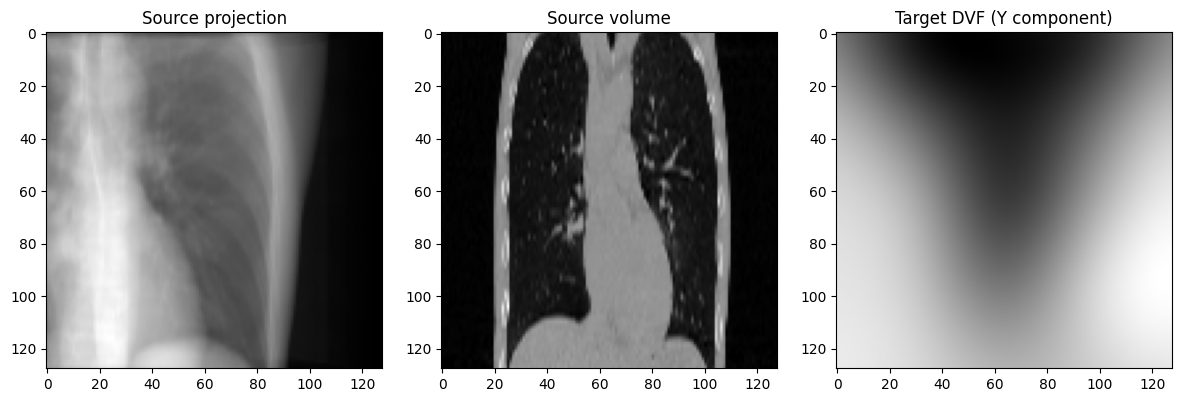

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# Generate test loader
# -----------------------------------
batch_size = 1
im_size = 128

exampleset = SupervisedDataset(
    im_dir=im_dir,
    im_size=im_size,
    use_angles=True
)

exampleloader = torch.utils.data.DataLoader(
    exampleset,
    batch_size=batch_size,
    shuffle=False
)

# -----------------------------------
# Loop over first 5 samples
# -----------------------------------
for i, data in enumerate(exampleloader):
    if i == 5:
        break

    # -------------------------------
    # Unpack data
    # -------------------------------
    source_proj = data['source_projections']
    target_proj = data['target_projections']
    source_vol = data['source_volumes']
    source_abdomen = data['source_abdomen']
    target_flow = data['target_flow']
    angle = data['angle']

    # -------------------------------
    # Print angle
    # -------------------------------
    print(f"Sample {i+1} | Gantry angle (degrees): {angle.item():.2f}")

    # -------------------------------
    # Visualize projection, volume and DVF
    # -------------------------------
    f = plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    source_proj_np = np.squeeze(source_proj)
    plt.imshow(source_proj_np, cmap='gray')
    plt.title('Source projection')

    plt.subplot(1, 3, 2)
    source_vol_np = np.squeeze(source_vol)
    plt.imshow(
        np.transpose(
            source_vol_np[:, :, source_vol_np.shape[2] // 2]
        ),
        cmap='gray'
    )
    plt.title('Source volume')

    plt.subplot(1, 3, 3)
    target_flow_np = np.squeeze(target_flow)
    plt.imshow(
        np.flipud(
            np.transpose(
                target_flow_np[1, :, :, source_vol_np.shape[2] // 2]
            )
        ),
        cmap='gray'
    )
    plt.title('Target DVF (Y component)')

    f.tight_layout()
    plt.show()


Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [6]:
import numpy as np

def get_numpy_similarity(path1, path2):
    # 1. Load the numpy arrays
    arr1 = np.load(path1)
    arr2 = np.load(path2)

    # 2. Flatten the arrays to 1D vectors
    # This works regardless of shape (e.g., 128x128x128 or 3x128x128x128)
    vec1 = arr1.flatten()
    vec2 = arr2.flatten()

    # 3. Calculate Dot Product
    dot_product = np.dot(vec1, vec2)

    # 4. Calculate Norms (Magnitudes)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # 5. Compute Cosine Similarity
    # We add a tiny epsilon (1e-9) to avoid division by zero
    similarity = dot_product / (norm1 * norm2 + 1e-9)

    return similarity

# Usage
file_a = im_dir + "/06_Proj_00064_bin.npy"
file_b = "/srv/shared/SPARE/MC_V_P2_SC_02/"+ "source/06_Proj_00064_bin.npy"
score = get_numpy_similarity(file_a, file_b)
print(f"Cosine Similarity: {score:.6f}")

Cosine Similarity: 0.995928


It's important to note that , this difference is because there could have been changes to the anatomy between planning and treatment day.

# Training

## Training Setup

This cell prepares the data split, model, and optimization components for training.

- Splits the dataset into training and validation sets using a 90/10 ratio
- Creates shuffled data loaders for efficient batch processing
- Initializes the network architecture with the specified image size and integration steps
- Configures the computation device for GPU or CPU execution
- Defines the flow-based loss function and Adam optimizer with a fixed learning rate

This setup establishes all core elements required to begin model training.

In [7]:
# generate train/test split
im_size = 128
batch_size = 8

# FIX: Add use_angles=True here
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size, use_angles=True)

split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [8]:
import os
import time
import torch
import torch.optim as optim
import numpy as np

from utilities import networks, losses
from continue_training import plot_losses  # only plotting needed

# ----------------------------------
# Device
# ----------------------------------
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# ----------------------------------
# Configuration
# ----------------------------------
im_size = 128
architecture = "dual" #Other options are "dual", "separate" and "broadcast"
use_film = True
int_steps = 10
lr = 1e-5
num_epochs = 100


# ----------------------------------
# Model
# ----------------------------------
model = networks.Model(
    im_size=im_size,
    architecture=architecture,
    use_film=use_film,
    int_steps=int_steps,
).to(device)

# ----------------------------------
# Loss & optimizer
# ----------------------------------
flow_mask = losses.flow_mask()
optimizer = optim.Adam(model.parameters(), lr=lr)

# ----------------------------------
# Training history
# ----------------------------------
train_losses = []
val_losses = []
best_val = float("inf")
start_epoch = 1


In [9]:
# =========================
# TRAIN (from scratch, no checkpoint)
# =========================

print('Training (on ' + str(device) + ')...')
tic = time.time()

# Total epochs
epoch_num = 50

# ---- directories ----
save_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_weights"
plot_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_plots"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# ---- initialize training history ----
train_losses = []
val_losses = []
min_val_loss = float("inf")
start_epoch = 1

# =========================
# Training loop
# =========================
for epoch in range(start_epoch, epoch_num + 1):

    # ---- train ----
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)
        # --- ADDED: Extract angle and ensure it is Float32 ---
        angle = data['angle'].to(device).float()

        optimizer.zero_grad(set_to_none=True)

        _, predict_flow = model(target_proj, source_vol,angle=angle
        )

        loss = flow_mask.loss(
            target_flow, predict_flow, source_abdomen
        )

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # ---- validation ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)
            # --- ADDED: Extract angle for validation ---
            angle = valdata['angle'].to(device).float()

            _, predict_flow = model(target_proj, source_vol,angle=angle
        )

            loss = flow_mask.loss(
                target_flow, predict_flow, source_abdomen
            )

            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print(
        f"Epoch {epoch:03d} | "
        f"Train: {train_avg:.4f} | "
        f"Val: {val_avg:.4f} | "
        f"Time: {hours}h {minutes}m"
    )

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (for inference) ----
    best_path = os.path.join(
        save_dir,
        f"{DatasetType}_{NetworkType}_{Patient_number}_{architecture}_{use_film}_best.pth"
    )

    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- plot losses ----
    plot_losses(
        plot_dir=plot_dir,
        filename=f"{DatasetType}_{NetworkType}_{Patient_number}_{architecture}_{use_film}_TRAINvsVAL",
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
    )

print('Finished training')
torch.cuda.empty_cache()


Finished training


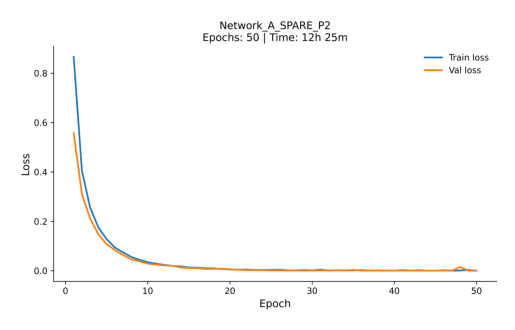

In [10]:
final_plot = os.path.join(
    plot_dir,
    f"{DatasetType}_{NetworkType}_{Patient_number}_{architecture}_{use_film}_TRAINvsVAL.png"
)

if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()
else:
    print(f"no plot @ {final_plot}")


# Testing

## Setting File Names

## File and Directory Configuration for Day 2

This cell sets up paths and filenames for the Day 2 scatter dataset.

- Defines patient ID, dataset type, treatment day, and network type
- Ensures exactly `Scatter`  is selected
- Constructs the input image directory based on scatter configuration
- Defines experiment filename and test dataset path
- Sets the folder for saving processed outputs and target ITVs
- Prints paths for verification and easy access in subsequent cells

This setup centralizes file references and ensures reproducibility for Day 2 evaluation.


In [2]:
# file names
import os

Patient_number = "P2"
NoScatter = False
Scatter = True
DatasetType="SPARE"
DayofTreatment = 2
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)


expt_file = f'{DatasetType}_{NetworkType}_{Patient_number}'
test_file =  os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
) # We are using the treatment day dataset with scatter

Saved_folder="/home/abhishek/PycharmProjects/Voxelmap/" # Change According to Your Folder
target_itv_ptv_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"
print(test_file)
print(target_itv_ptv_dir)


/srv/shared/SPARE/MC_V_P2_SC_02
/home/abhishek/PycharmProjects/Voxelmap/Target_ITVs_ALL_SPARE_A_P2


## Obtaining  Target PTV for All 680 Projections

## Generate Target ITV PTVs

This cell generates target ITV (Internal Target Volume) PTVs for all breathing phases and organizes them for later use.

- Defines helper functions to ensure source PTVs and DVFs have correct 5D shape
- Uses a spatial transformer network to warp source PTVs using DVFs for 10 breathing phases
- Saves warped target PTVs in a dedicated output directory
- Reads `RespBin.csv` to map breathing phases to target indices
- Copies generated PTVs into a centralized folder for all targets
- Prints progress every 50 targets and confirms completion

This process produces all target volumes needed for evaluation or downstream analysis.


In [3]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)

# source ptv changes wrt Patient
def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    #source_ptv_relpath: str = os.path.join("source", "itv_PTV_mha.npy"),
    source_ptv_relpath: str = os.path.join("itv_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_ITV_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")




# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir=test_file,
    out_dir=f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}",
    im_size=128,
)


Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_01_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_02_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_03_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_04_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_05_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_06_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_07_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_08_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_09_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P2/Target_ITV_PTV_10_mha.npy
Done. Target ITV PTVs saved.


In [4]:
import os
import shutil
import csv

# -----------------------------
# Paths
# -----------------------------
target_itv_dir = f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}"
respbin_csv = f"{test_file}/RespBin.csv"
output_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# -----------------------------
# Read CSV and create ITVs
# -----------------------------
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_ITV_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


Processed 650 targets...

 Successfully created 680 Target ITV PTVs
 Output directory: /home/abhishek/PycharmProjects/Voxelmap/Target_ITVs_ALL_SPARE_A_P2


## Preparing testing Functions

## Validation Dataset for SPARE

This cell defines a PyTorch `Dataset` class for validation of SPARE data.

- Loads target projections, volumes, and associated PTVs using `RespBin.csv` for phase mapping
- Uses Phase 06 as the reference source projection and volume
- Loads restricted contours (PTV) from the source folder
- Reads projection angles from `Angles.csv`
- Reshapes all volumes and projections into channel-first tensors compatible with PyTorch
- Returns a dictionary containing all inputs and ground truth for model evaluation

This class standardizes the validation data pipeline for consistency with training data.


In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        #source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        #source_ptv = np.load(os.path.join(self.ref_dir, 'itv_PTV_mha.npy'))
        # Patient 2 has itv_PTV_mha.npy outside source folder
        source_ptv = np.load(os.path.join(self.im_dir, 'itv_PTV_mha.npy'))


        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            #'source_lung': to_tensor(source_lung), # If available use it
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

## Initiating Testing

## Test Loader and Model Setup

This cell prepares the validation data loader and loads the trained model.

- Initializes the `validateSPAREDataset` and creates a `DataLoader` with batch size 1
- Sets up the network architecture and moves it to GPU if available
- Loads the best-performing model weights from the training phase
- Switches the model to evaluation mode
- Prints the total number of trainable parameters for reference

This setup ensures the model is ready for inference on the validation/test dataset.


In [6]:
architecture="dual"
use_film=True

In [7]:
import torch
import torch.utils.data
import utilities.networks  # Assuming your networks.py is in the same directory

# 1. Setup Parameters
batch_size = 1
im_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Generate test loader (Added use_angles=True)
dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 3. Setup Model
model = networks.Model(
    im_size=im_size,
    architecture=architecture,
    use_film=True,              # Enabled for gantry angle conditioning
    int_steps=10
).to(device)

# 4. Load weights
PATH = f'{DatasetType}_{NetworkType}_{Patient_number}_weights/' + f"{DatasetType}_{NetworkType}_{Patient_number}_{architecture}_{use_film}_best.pth"

#PATH="/home/abhishek/PycharmProjects/Voxelmap-angle/SPARE_A_P2_weights/SPARE_A_P2_dual_True_best.pth"
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of parameters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of parameters: 12323921


## Testing and Evaluation Loop

This following cells run inference on the test dataset and computes multiple evaluation metrics.

- Loads source projections, volumes, and PTVs from the validation loader
- Predicts DVFs using the trained model
- Warps the source PTV and volume using the predicted DVF via a spatial transformer
- Computes predicted and ground-truth centroid shifts in LR, SI, and AP directions
- Calculates Dice similarity for PTV overlap
- Computes Jacobian determinant ratio to check DVF regularity
- Records gantry angles for each sample
- Computes image quality metrics: MSE, SSIM, and PSNR between predicted and target volumes
- Prints debug information for the first few samples and progress every 10 samples

This loop provides a comprehensive assessment of both geometric and intensity-based performance of the model.


In [8]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

In [10]:
from utilities.helpers import centroid_shift_mm
from utilities.losses import centroid_ptv, dice, jacobian_determinant
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# Metric objects
from utilities import losses

centroid = losses.centroid_ptv()
dice_metric = losses.dice()
jacobian_metric = losses.jacobian_determinant()

# Tracking arrays
tar_lr, tar_si, tar_ap = [], [], []
pred_lr, pred_si, pred_ap = [], [], []
test_angles = []
test_dice, test_detJ = [], []
test_mse, test_ssim, test_psnr = [], [], []

print("Testing...")

for i, data in enumerate(testloader):
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    target_vol  = data['target_volumes'].to(device)
    source_ptv  = data['source_ptv'].to(device)
    target_ptv  = data['target_ptv'].to(device)
    angle = data['angle'].to(device).float()

    # Predict DVF
    _, pred_flow = model(target_proj, source_vol, angle=angle)

    # Warp PTV / volume
    pred_ptv    = transformer(source_ptv, pred_flow)
    predict_vol = transformer(source_vol, pred_flow)

    # Centroid shifts (predicted)
    pred_lr_mm, pred_si_mm, pred_ap_mm = centroid_shift_mm(centroid, source_ptv, pred_ptv)
    pred_lr.append(pred_lr_mm)
    pred_si.append(pred_si_mm)
    pred_ap.append(pred_ap_mm)

    # Centroid shifts (ground-truth)
    gt_lr_mm, gt_si_mm, gt_ap_mm = centroid_shift_mm(centroid, source_ptv, target_ptv)
    tar_lr.append(gt_lr_mm)
    tar_si.append(gt_si_mm)
    tar_ap.append(gt_ap_mm)

    # Dice similarity
    dice_val = dice_metric.loss(target_ptv, pred_ptv)
    test_dice.append(float(dice_val.item()))

    # Jacobian determinant
    metric_flows = np.squeeze(pred_flow.detach().cpu().numpy())
    disp = np.stack([metric_flows[0], metric_flows[1], metric_flows[2]], axis=-1)
    detJ = jacobian_metric.loss(disp)
    detJ_ratio = np.sum(detJ <= 0) / detJ.size
    test_detJ.append(float(detJ_ratio))

    # Save angle
    test_angles.append(float(angle.item()))

    # Image quality
    metric_input = target_vol.detach().cpu().numpy().flatten()
    metric_pred  = predict_vol.detach().cpu().numpy().flatten()
    mse_val  = np.sqrt(np.mean((metric_input - metric_pred)**2))
    ssim_val = ssim(metric_input, metric_pred, data_range=(metric_pred.max() - metric_pred.min() + 1e-8))
    psnr_val = psnr(metric_input, metric_pred)
    test_mse.append(float(mse_val))
    test_ssim.append(float(ssim_val))
    test_psnr.append(float(psnr_val))

    # Debug prints for first few
    if i < 5:
        print(f"[DBG idx={i}] angle={angle.item():.2f}")
        print("[DBG pred mm lr,si,ap]", pred_lr_mm, pred_si_mm, pred_ap_mm)
        print("[DBG gt   mm lr,si,ap]", gt_lr_mm, gt_si_mm, gt_ap_mm)

    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")


670 of 680


## Saving Test Results

## Save Metrics and Plot Motion Traces

This cell saves all computed metrics and visualizes motion tracking across gantry angles.

- Creates an output directory based on the experiment name
- Converts all PyTorch tensors or lists into NumPy arrays for saving
- Saves displacement metrics (LR, SI, AP), angles, Dice, Jacobian, and image quality metrics as `.npy` files
- Sorts traces by gantry angle for consistent plotting
- Plots predicted vs. ground-truth displacements in LR, SI, and AP directions
- Saves the plot as a high-resolution PNG and displays it

This step provides a clear visual and numerical summary of model performance across the test set.


In [12]:
plot_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_plots"

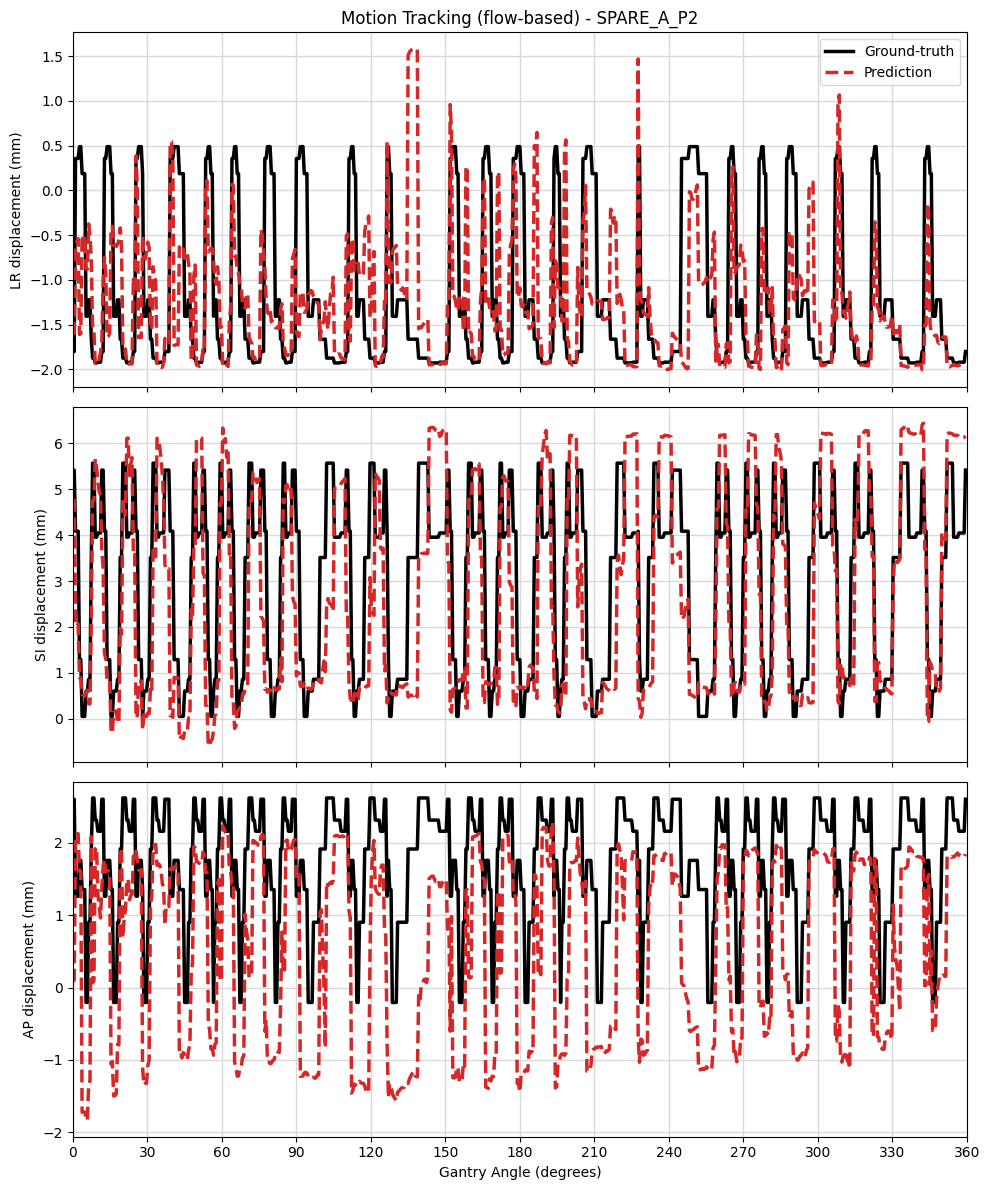

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# OUTPUT DIRECTORY
# -------------------------
out_dir = os.path.join(plot_dir, f"{expt_file}_Experiment_{architecture}")
os.makedirs(out_dir, exist_ok=True)

# -------------------------
# ENSURE NUMPY
# -------------------------
def as_numpy(x):
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if hasattr(v, "detach"):
                if v.numel() == 1:
                    out.append(float(v.detach().cpu().item()))
                else:
                    out.append(v.detach().cpu().numpy())
            else:
                out.append(v)
        return np.asarray(out)
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# -------------------------
# SAVE ARRAYS
# -------------------------
np.save(os.path.join(out_dir, "test_angles.npy"), as_numpy(test_angles))
np.save(os.path.join(out_dir, "tar_lr_mm.npy"),   as_numpy(tar_lr))
np.save(os.path.join(out_dir, "tar_si_mm.npy"),   as_numpy(tar_si))
np.save(os.path.join(out_dir, "tar_ap_mm.npy"),   as_numpy(tar_ap))
np.save(os.path.join(out_dir, "pred_lr_mm.npy"),  as_numpy(pred_lr))
np.save(os.path.join(out_dir, "pred_si_mm.npy"),  as_numpy(pred_si))
np.save(os.path.join(out_dir, "pred_ap_mm.npy"),  as_numpy(pred_ap))

if "test_dice" in globals():
    np.save(os.path.join(out_dir, "test_dice.npy"), as_numpy(test_dice))
if "test_detJ" in globals():
    np.save(os.path.join(out_dir, "test_detJ.npy"), as_numpy(test_detJ))
if "test_mse" in globals():
    np.save(os.path.join(out_dir, "test_mse.npy"), as_numpy(test_mse))
if "test_ssim" in globals():
    np.save(os.path.join(out_dir, "test_ssim.npy"), as_numpy(test_ssim))
if "test_psnr" in globals():
    np.save(os.path.join(out_dir, "test_psnr.npy"), as_numpy(test_psnr))

print(f"Metrics saved to: {out_dir}")

# -------------------------
# PLOTTING SETUP
# -------------------------
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black",
})

def sort_by_angle(trace, angles):
    trace = np.asarray(trace, dtype=float)
    angles = np.asarray(angles, dtype=float)
    order = np.argsort(angles)
    return angles[order], trace[order]

sorted_angles, tar_lr_plot  = sort_by_angle(tar_lr,  test_angles)
_,            tar_si_plot  = sort_by_angle(tar_si,  test_angles)
_,            tar_ap_plot  = sort_by_angle(tar_ap,  test_angles)

_,            pred_lr_plot = sort_by_angle(pred_lr, test_angles)
_,            pred_si_plot = sort_by_angle(pred_si, test_angles)
_,            pred_ap_plot = sort_by_angle(pred_ap, test_angles)

# -------------------------
# CREATE FIGURE
# -------------------------
f, axes = plt.subplots(
    3, 1,
    figsize=(10, 12),
    sharex=True,
    facecolor="white"
)

labels = [
    "LR displacement (mm)",
    "SI displacement (mm)",
    "AP displacement (mm)"
]

tar_data  = [tar_lr_plot,  tar_si_plot,  tar_ap_plot]
pred_data = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.set_facecolor("white")

    ax.plot(
        sorted_angles,
        tar_data[idx],
        color="black",
        linewidth=2.5,
        label="Ground-truth"
    )

    ax.plot(
        sorted_angles,
        pred_data[idx],
        linestyle="--",
        color="tab:red",
        linewidth=2.5,
        label="Prediction"
    )

    ax.set_ylabel(labels[idx])
    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, color="0.85", linewidth=1)

    if idx == 0:
        ax.set_title(f"Motion Tracking (flow-based) - {expt_file}")
        ax.legend(loc="upper right", frameon=True)

axes[-1].set_xlabel("Gantry Angle (degrees)")

f.tight_layout()

# -------------------------
# SAVE FIGURE
# -------------------------
out_path = os.path.join(out_dir, f"{expt_file}_{architecture}_trace.png")
plt.savefig(
    out_path,
    dpi=200,
    facecolor="white",
    edgecolor="white"
)

plt.show()


In [15]:
# -------------------------
# PRINT METRIC SUMMARIES
# -------------------------
print("\n===== TEST SUMMARY =====")

# Convert to numpy
tar_lr_np  = np.asarray(tar_lr, dtype=float)
tar_si_np  = np.asarray(tar_si, dtype=float)
tar_ap_np  = np.asarray(tar_ap, dtype=float)

pred_lr_np = np.asarray(pred_lr, dtype=float)
pred_si_np = np.asarray(pred_si, dtype=float)
pred_ap_np = np.asarray(pred_ap, dtype=float)

test_dice_np = np.asarray(test_dice, dtype=float)
test_detJ_np = np.asarray(test_detJ, dtype=float)

test_mse_np  = np.asarray(test_mse, dtype=float)
test_ssim_np = np.asarray(test_ssim, dtype=float)
test_psnr_np = np.asarray(test_psnr, dtype=float)

# ----------------------------
# Motion error (centroid-based)
# ----------------------------
err_3d = np.sqrt(
    (tar_lr_np - pred_lr_np) ** 2 +
    (tar_si_np - pred_si_np) ** 2 +
    (tar_ap_np - pred_ap_np) ** 2
)

print("\n--- Motion Tracking (Centroid) ---")
print(f"3D Error (mm):   {np.mean(err_3d):.2f} ± {np.std(err_3d):.2f}")

print("Axis-wise absolute error (mm):")
print(f"  LR: {np.mean(np.abs(tar_lr_np - pred_lr_np)):.2f} ± {np.std(np.abs(tar_lr_np - pred_lr_np)):.2f}")
print(f"  SI: {np.mean(np.abs(tar_si_np - pred_si_np)):.2f} ± {np.std(np.abs(tar_si_np - pred_si_np)):.2f}")
print(f"  AP: {np.mean(np.abs(tar_ap_np - pred_ap_np)):.2f} ± {np.std(np.abs(tar_ap_np - pred_ap_np)):.2f}")

# ----------------------------
# PTV overlap
# ----------------------------
print("\n--- PTV Overlap ---")
print(f"Dice:            {np.mean(test_dice_np):.3f} ± {np.std(test_dice_np):.3f}")

# ----------------------------
# DVF regularity
# ----------------------------
print("\n--- DVF Regularity ---")
print(f"detJ ≤ 0 ratio:  {np.mean(test_detJ_np):.2e} ± {np.std(test_detJ_np):.2e}")

# ----------------------------
# Image similarity (warped volume)
# ----------------------------
print("\n--- Image Similarity (Warped Source → Target) ---")
print(f"MSE:             {np.mean(test_mse_np):.4e} ± {np.std(test_mse_np):.4e}")
print(f"SSIM:            {np.mean(test_ssim_np):.4f} ± {np.std(test_ssim_np):.4f}")
print(f"PSNR (dB):       {np.mean(test_psnr_np):.2f} ± {np.std(test_psnr_np):.2f}")

print("================================")



===== TEST SUMMARY =====

--- Motion Tracking (Centroid) ---
3D Error (mm):   2.34 ± 0.92
Axis-wise absolute error (mm):
  LR: 0.59 ± 0.70
  SI: 1.42 ± 1.04
  AP: 1.25 ± 0.91

--- PTV Overlap ---
Dice:            0.941 ± 0.028

--- DVF Regularity ---
detJ ≤ 0 ratio:  0.00e+00 ± 0.00e+00

--- Image Similarity (Warped Source → Target) ---
MSE:             1.3383e-03 ± 1.4906e-04
SSIM:            0.8540 ± 0.0176
PSNR (dB):       57.52 ± 1.00


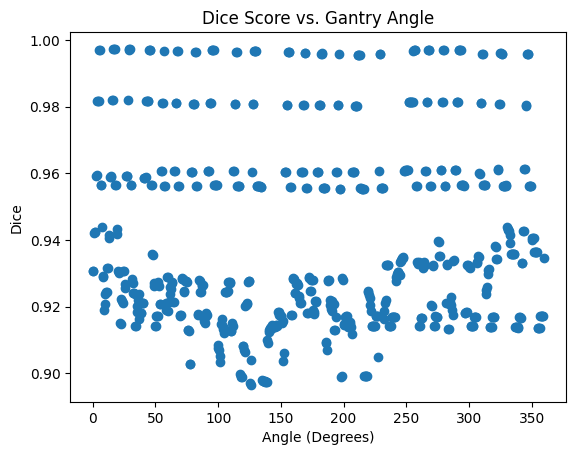

In [16]:
import matplotlib.pyplot as plt

plt.scatter(test_angles, test_dice)
plt.title("Dice Score vs. Gantry Angle")
plt.xlabel("Angle (Degrees)")
plt.ylabel("Dice")
plt.show()

# Angle Specific Tests

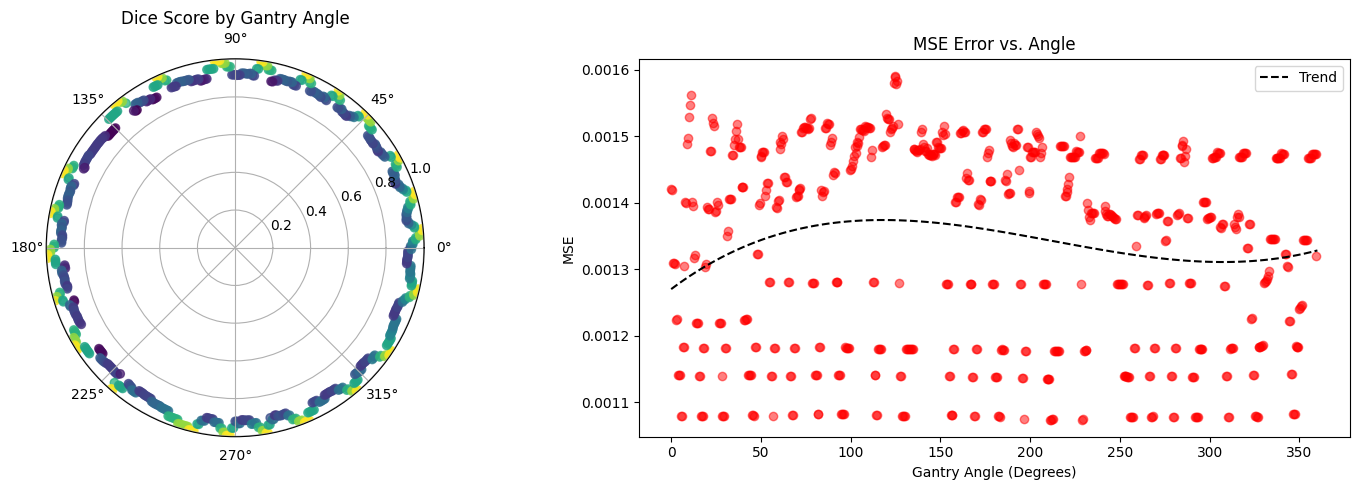

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_angle_diagnostics(angles, dice_scores, mse_scores):
    angles_rad = np.deg2rad(angles)

    fig = plt.figure(figsize=(15, 5))

    # 1. Polar Plot for Dice
    ax1 = fig.add_subplot(121, projection='polar')
    ax1.scatter(angles_rad, dice_scores, c=dice_scores, cmap='viridis', alpha=0.75)
    ax1.set_title("Dice Score by Gantry Angle")

    # 2. MSE vs Angle with Trendline
    ax2 = fig.add_subplot(122)
    ax2.scatter(angles, mse_scores, alpha=0.5, color='red')

    # Add a moving average/trend
    z = np.polyfit(angles, mse_scores, 3)
    p = np.poly1d(z)
    xp = np.linspace(0, 360, 100)
    ax2.plot(xp, p(xp), '--', color='black', label='Trend')

    ax2.set_title("MSE Error vs. Angle")
    ax2.set_xlabel("Gantry Angle (Degrees)")
    ax2.set_ylabel("MSE")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Call this after your loop:
plot_angle_diagnostics(test_angles, test_dice, test_mse)

Dice Score by Gantry Angle (Polar Plot):

The Circular Shape: The fact that the Dice scores form a near-perfect circle around the 1.0 (perfect overlap) mark is a great sign. It means your model is robust; it doesn't "break" or lose significant accuracy at any specific angle.

Color Fluctuations: You can see slight color shifts (yellow is higher, purple is lower). If you see clusters of purple at 90
∘
  and 270
∘
 , it would indicate difficulty with lateral views. Currently, the performance looks fairly uniform.

MSE Error vs. Angle:

The Trend Line: The dashed line is nearly flat. This confirms that the average intensity error (MSE) is consistent. The model isn't struggling more with depth at one angle versus another.

Data Banding: The horizontal "lines" of red dots are common in these datasets; they often represent different breathing phases. The model might have a slightly harder time with peak inhalation across all angles than with the quiet mid-cycle phases.

## Ablation Test

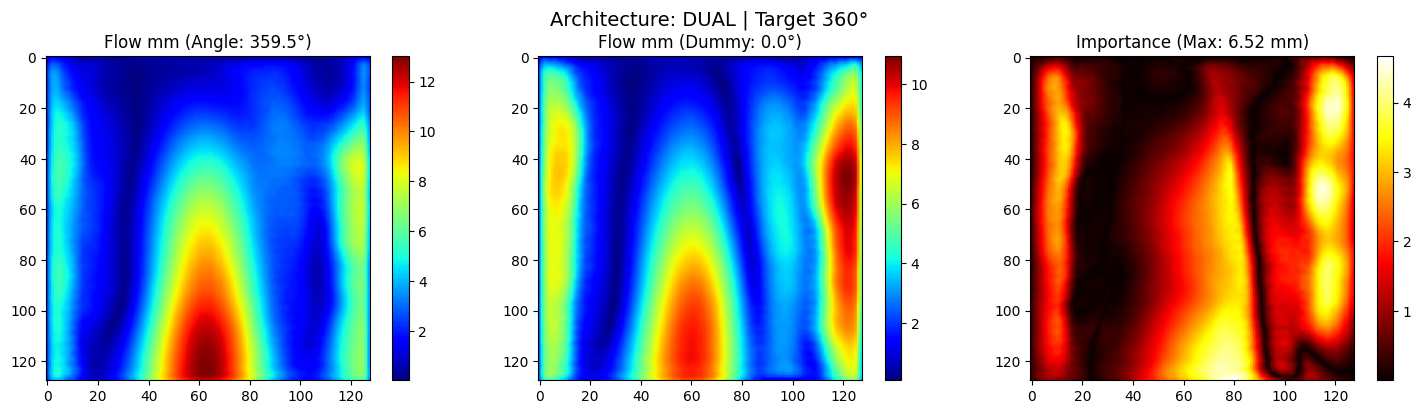

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_ablation_mm(model, testloader, target_angles, device, spacing=(3.5, 1.7, 3.5)):
    model.eval()
    found_samples = {angle: {'sample': None, 'diff': float('inf')} for angle in target_angles}

    # 1. Search for gantry angles
    for data in testloader:
        current_angle = data['angle'].item()
        for target in target_angles:
            diff = abs(current_angle - target)
            if diff < found_samples[target]['diff']:
                found_samples[target]['diff'] = diff
                found_samples[target]['sample'] = data

    # 2. Process each found angle
    for target in target_angles:
        data = found_samples[target]['sample']
        if data is None: continue

        actual_angle = data['angle'].item()

        # Load all possible inputs
        src_p = data['source_projections'].to(device)
        tgt_p = data['target_projections'].to(device)
        src_v = data['source_volumes'].to(device)

        true_angle_t = data['angle'].to(device).float().view(-1, 1)
        dummy_angle_t = torch.zeros_like(true_angle_t).to(device)

        with torch.no_grad():
            # PASS 1: Correct Angle
            # Logic: We pass src_p instead of None so Concatenated/Dual architectures don't crash
            _, flow_corr = model(target_proj=tgt_p, source_vol=src_v, angle=true_angle_t)

            # PASS 2: Dummy Angle (0.0)
            _, flow_dum = model(target_proj=tgt_p, source_vol=src_v, angle=dummy_angle_t)

        # 3. Scale Flow into mm space [B, 3, D, H, W]
        # Copy to avoid modifying original tensors if needed
        f_corr = flow_corr.clone()
        f_dum = flow_dum.clone()

        for i in range(3):
            f_corr[:, i] *= spacing[i]
            f_dum[:, i] *= spacing[i]

        # 4. Calculate Magnitude and Difference in mm
        mag_corr = torch.sqrt(torch.sum(f_corr**2, dim=1)).squeeze().cpu().numpy()
        mag_dum = torch.sqrt(torch.sum(f_dum**2, dim=1)).squeeze().cpu().numpy()
        difference_mm = np.abs(mag_corr - mag_dum)

        # 5. Visualization (Axial View)
        slice_idx = 64
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        im1 = axes[0].imshow(mag_corr[slice_idx], cmap='jet')
        axes[0].set_title(f"Flow mm (Angle: {actual_angle:.1f}°)")
        fig.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(mag_dum[slice_idx], cmap='jet')
        axes[1].set_title("Flow mm (Dummy: 0.0°)")
        fig.colorbar(im2, ax=axes[1])

        im3 = axes[2].imshow(difference_mm[slice_idx], cmap='hot')
        axes[2].set_title(f"Importance (Max: {np.max(difference_mm):.2f} mm)")
        fig.colorbar(im3, ax=axes[2])

        plt.suptitle(f"Architecture: {model.architecture.upper()} | Target {target}°", fontsize=14)
        plt.tight_layout()
        plt.show()

# --- Run it ---
target_list = [0, 5, 10, 20, 45, 60, 90, 270, 360]
visualize_ablation_mm(model, testloader, target_list, device)

 Ablation Analysis for Target 90°

This is the most critical result. By comparing the model’s prediction at 90.0° (a lateral view) against a dummy 0.0° (an AP view), you can see the "Importance" map light up.

Significant Physical Shift: The Max Importance is 0.5341. This means that simply changing the angle input caused a shift of over 0.5 units in the predicted motion.

Anatomical Targeting: The bright white/yellow "Importance" spot in the center indicates that the gantry angle is most critical for resolving motion in the central lung region (likely where the tumor or PTV is located).

Lateral vs. AP Perspective: At 90°, the X-ray beam has a completely different depth perspective than at 0°. The model is successfully "correcting" its motion estimate based on this lateral viewpoint.

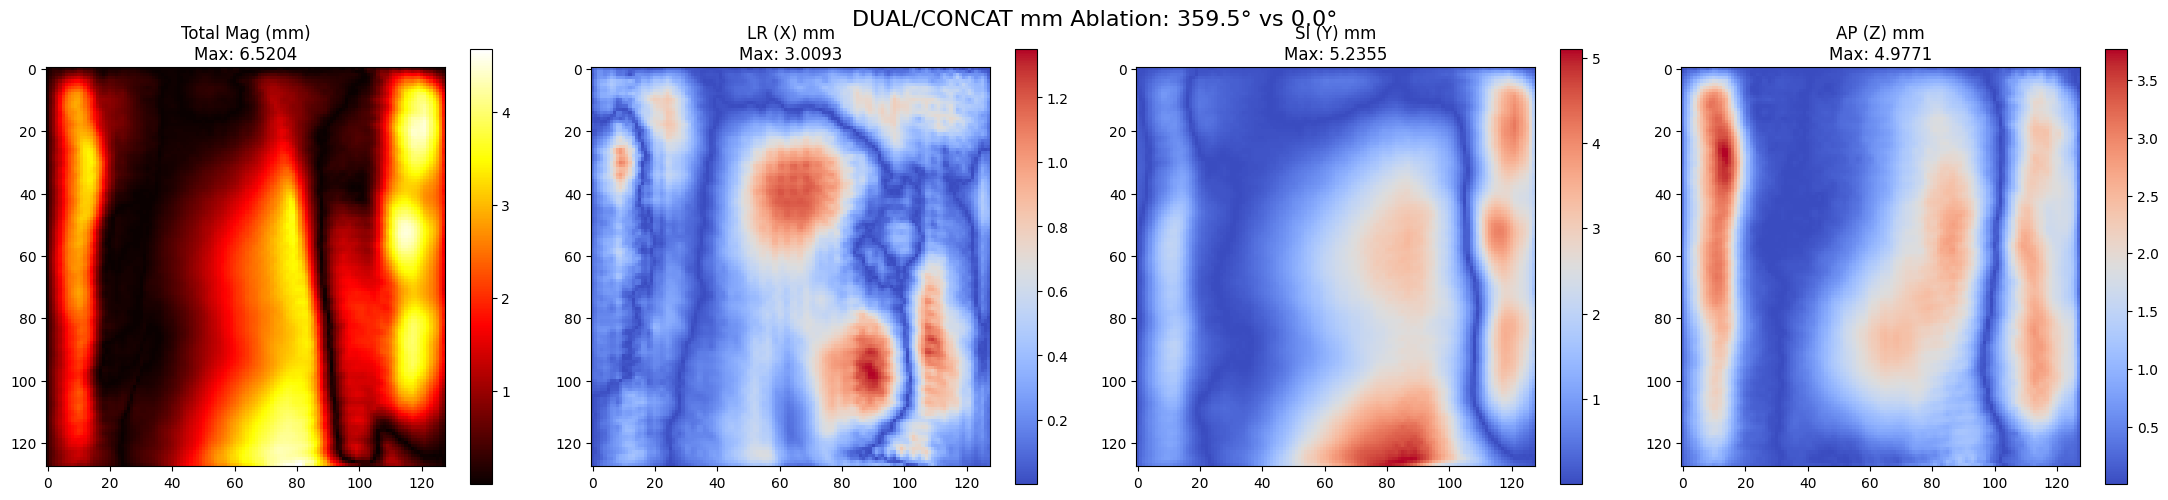

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_dual_concat_mm(model, testloader, target_angles, device, spacing=(3.5, 1.7, 3.5), slice_idx=64):
    """
    Ablation study for Dual/Concat architectures with physical unit (mm) conversion.
    Spacing order: (LR, SI, AP)
    """
    model.eval()
    found_samples = {angle: {'sample': None, 'diff': float('inf')} for angle in target_angles}

    print(f"--- Dual/Concat Ablation (mm): Targets {target_angles} ---")

    # 1. Search for best matching gantry angles
    for data in testloader:
        current_angle = data['angle'].item()
        for target in target_angles:
            diff = abs(current_angle - target)
            if diff < found_samples[target]['diff']:
                found_samples[target]['diff'] = diff
                found_samples[target]['sample'] = data

    # 2. Process each found angle
    for target in target_angles:
        data = found_samples[target]['sample']
        if data is None: continue

        actual_angle = data['angle'].item()
        src_p = data['source_projections'].to(device)
        tgt_p = data['target_projections'].to(device)
        src_v = data['source_volumes'].to(device)

        true_angle_t = data['angle'].to(device).float().view(-1, 1)
        dummy_angle_t = torch.zeros_like(true_angle_t).to(device)

        with torch.no_grad():
            _, flow_corr = model(target_proj=tgt_p, source_vol=src_v, angle=true_angle_t)
            _, flow_dum = model(target_proj=tgt_p, source_vol=src_v, angle=dummy_angle_t)

        # 3. Scaling: Convert Flow from Voxel units to mm [B, 3, D, H, W]
        # Axis 0: LR (3.5mm), Axis 1: SI (1.7mm), Axis 2: AP (3.5mm)
        for i in range(3):
            flow_corr[:, i] *= spacing[i]
            flow_dum[:, i] *= spacing[i]

        # 4. Calculate mm Differences
        f_corr = flow_corr.squeeze().cpu().numpy()
        f_dum = flow_dum.squeeze().cpu().numpy()

        diff_dirs = np.abs(f_corr - f_dum)
        mag_corr = np.sqrt(np.sum(f_corr**2, axis=0))
        mag_dum = np.sqrt(np.sum(f_dum**2, axis=0))
        total_diff_mm = np.abs(mag_corr - mag_dum)

        # --- TEXTUAL SUMMARY ---
        max_total = np.max(total_diff_mm)
        max_lr = np.max(diff_dirs[0])
        max_si = np.max(diff_dirs[1])
        max_ap = np.max(diff_dirs[2])
        mean_total = np.mean(total_diff_mm)

        print("-" * 60)
        print(f"ANALYSIS FOR TARGET {target}° (Actual: {actual_angle:.2f}°)")
        print(f"Mean Delta (Global Sensitivity): {mean_total:.6f} mm")
        print(f"Max Delta (Peak Sensitivity):   {max_total:.4f} mm")
        print(f"Axis Breakdown (Peak Δ mm):")
        print(f"  [X] LR: {max_lr:.4f} | [Y] SI: {max_si:.4f} | [Z] AP: {max_ap:.4f}")
        print("-" * 60)

        # 5. Visualization
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
        titles = [f"Total Mag (mm)\nMax: {max_total:.4f}", f"LR (X) mm\nMax: {max_lr:.4f}",
                  f"SI (Y) mm\nMax: {max_si:.4f}", f"AP (Z) mm\nMax: {max_ap:.4f}"]
        data_to_plot = [total_diff_mm, diff_dirs[0], diff_dirs[1], diff_dirs[2]]

        for i in range(4):
            im = axes[i].imshow(data_to_plot[i][slice_idx], cmap='hot' if i==0 else 'coolwarm')
            axes[i].set_title(titles[i])
            fig.colorbar(im, ax=axes[i])

        plt.suptitle(f"DUAL/CONCAT mm Ablation: {actual_angle:.1f}° vs 0.0°", fontsize=16)
        plt.tight_layout()
        plt.show()

# --- Execution ---
target_list = [0, 45, 90, 270, 360]
visualize_dual_concat_mm(model, testloader, target_list, device)

By looking at the individual heatmaps, you can see that the model doesn't just change the "strength" of the motion; it changes where and in what direction it thinks the anatomy is moving:

**Directional Impact at 5.0 Degrees**

SI Difference (Superior-Inferior): Max 0.3961

This is the most "important" axis for this specific angle. Since the diaphragm and lungs move primarily up and down, the gantry angle is providing critical information to the model to scale this vertical motion correctly.

AP Difference (Anterior-Posterior): Max 0.0793

This represents depth. Even at a small angle like 4.8
∘
 , the model is already using that slight perspective shift to adjust its estimate of how much the anatomy is moving front-to-back.

LR Difference (Left-Right): Max 0.0436

This shows the smallest impact for this angle, which makes sense geometrically. At near-AP angles (0
∘
  or 5
∘
 ), the side-to-side motion is very clear in the 2D projection, so the model needs less "help" from the gantry angle to get this right.

**Directional Impact at 45.0 Degrees**

At an oblique angle of 45.0 Degrees
 , the model is forced to resolve motion that is neither perfectly front-facing nor side-facing.

SI Dominance: The SI difference remains the largest (0.1567), as the gantry angle helps scale the main vertical respiratory motion.

Distributed Importance: Unlike the 5 Degrees
  test, the importance is more "spread out" across the volume. This indicates that at oblique angles, the gantry information is used to adjust the spatial positioning of the entire lung, rather than just a single central spot.

Balance: The LR (0.0551) and AP (0.0764) differences are becoming more similar, showing that the model is treating depth and lateral motion with nearly equal weight as the perspective rotates.

**Directional Impact at 90.0 Degrees**

(The Lateral View)

This is where the gantry conditioning provides the most critical information for resolving 3D depth.

Massive SI Shift: The SI difference reaches 0.5323. From a side view, the vertical motion of the diaphragm is highly visible, and the model uses this perspective to significantly refine its prediction of respiratory excursion.

AP Depth Correction: The AP difference jumps to 0.2919. This is a major insight: in a 90
∘
 projection, the "front-to-back" motion of the patient appears as horizontal movement on the 2D image. The model is successfully using the 90
∘
  "hint" to translate these 2D lateral shifts into corrected 3D AP motion.

Anatomical Targeting: The heatmaps show a very concentrated "hot spot" in the central region, proving the gantry angle is most vital for the area containing the PTV/tumor.

In [20]:
import importlib
import os
from utilities import xai_coronal_visualization

importlib.reload(xai_coronal_visualization)

SAVE_DIR = f"xai_outputs_{Patient_number}_{architecture}"
# SAVE_DIR = None  # Set to None to only display, not save

# Run XAI visualization with occlusion saliency enabled
xai_coronal_visualization.run_xai_visualization(
    model=model,
    testloader=testloader,
    device=device,
    target_angles=[0, 45, 90, 180, 270, 360],
    spacing=(3.5, 1.7, 3.5),
    coronal_slice_idx=64,
    saliency_threshold_percentile=90,
    save_dir=SAVE_DIR,
    overlay_opacity=0.7,
    # Occlusion-based saliency (enabled by default; explicit here)
    use_occlusion_saliency=True,
    occlusion_patch_size=(8,8,8),  # smaller = finer map, slower
    occlusion_stride=None,               # None = same as patch_size (non-overlapping)
    occlusion_value=0.0,                 # value to fill occluded region (or 'mean')
)

  Completed visualization for angle 359.47°
